# CNN with a Trainable Embedding Layer - Why aren't we getting better results?
## Redoing with 80/10/10 split

Trying predictions on chunks of the input in order to find where the signal is in the underlying documents.

In [1]:
%matplotlib inline

import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text

import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

## Build test and training sets & define preprocessing

In [3]:
NUM_WORDS = 50000
MAXLEN = 5000
NGRAM_RANGE = 1

In [4]:
train, test, preproc = text.texts_from_csv('../data/train_80_10_10.csv',
                                          'cleaned_contents',
                                          label_columns=['Discrimination_Label'],
                                          val_filepath='../data/val_80_10_10.csv',
                                          max_features=NUM_WORDS,
                                          maxlen=MAXLEN,
                                          ngram_range=NGRAM_RANGE)

detected encoding: utf-8 (if wrong, set manually)
language: en
Word Counts: 17531
Nrows: 647
647 train sequences
train sequence lengths:
	mean : 1501
	95percentile : 3939
	99percentile : 7668
x_train shape: (647,5000)
y_train shape: (647, 2)
Is Multi-Label? False
81 test sequences
test sequence lengths:
	mean : 1510
	95percentile : 4141
	99percentile : 5507
x_test shape: (81,5000)
y_test shape: (81, 2)


## Build the model

In [5]:
def _build_cnn(maxlen, max_features, embed_dim, filters, kernels,
               dropout=0.1,
               loss_func='categorical_crossentropy',
               activation = 'softmax', metrics=['accuracy'],
               verbose=1, optimizer='adam'):
    
    embedding_matrix = np.ones((max_features, 1))
    embedding_matrix[0] = 0

    # set up the model
    inp = tf.keras.layers.Input(shape=(maxlen,))
    x = tf.keras.layers.Embedding(max_features, embed_dim, input_length=maxlen, 
                                  trainable=True)(inp)
    x0 = tf.keras.layers.Conv1D(filters=filters,
                               kernel_size=kernels[0],
                               activation='relu')(x)
    x0 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[0] + 1)(x0)

    x1 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[1],
                                activation='relu')(x)
    x1 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[1] + 1)(x1)
    
    x2 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[2],
                                activation='relu')(x)
    x2 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[2] + 1)(x2)
    
    x3 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[3],
                                activation='relu')(x)
    x3 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[3] + 1)(x3)

    x4 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[4],
                                activation='relu')(x)
    x4 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[4] + 1)(x4)

    x = tf.keras.layers.concatenate([x0, x1, x2, x3, x4])

    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(2, activation=activation)(x)
    model = tf.keras.Model(inputs=inp, outputs=outputs)
    model.compile(loss=loss_func,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [6]:
model = _build_cnn(MAXLEN, 50000, 100, filters=32, kernels=[2, 3, 4, 5, 6], dropout=0.4)
learner = ktrain.get_learner(model, train_data=train, val_data=test)

In [7]:
learner.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5000, 100)    5000000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 4999, 32)     6432        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4998, 32)     9632        embedding[0][0]                  
______________________________________________________________________________________________

## Define and train the model

### Train

In [8]:
learner.autofit(0.001, early_stopping=5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 81 samples
Epoch 1/1024
647/647 [==============================] - 7s 10ms/sample - loss: 0.6811 - accuracy: 0.5564 - val_loss: 0.6725 - val_accuracy: 0.5926
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6556 - accuracy: 0.6090 - val_loss: 0.6665 - val_accuracy: 0.5926
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6244 - accuracy: 0.6785 - val_loss: 0.6523 - val_accuracy: 0.5926
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.5661 - accuracy: 0.7821 - val_loss: 0.6558 - val_accuracy: 0.7160
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.5113 - accuracy: 0.8532 - val_loss: 0.6383 - val_accuracy: 0.6667
Epoch 6/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.4390 - accu

## Examine results

In [9]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

           0       0.64      0.42      0.51        33
           1       0.68      0.83      0.75        48

    accuracy                           0.67        81
   macro avg       0.66      0.63      0.63        81
weighted avg       0.66      0.67      0.65        81



array([[14, 19],
       [ 8, 40]])

In [10]:
test_x = list(pd.read_csv('../data/test_80_10_10.csv')['cleaned_contents'])
predictor = ktrain.get_predictor(learner.model, preproc=preproc)
y_hat = np.array(predictor.predict(test_x), dtype=np.int64)
y = np.array(pd.read_csv('../data/test_80_10_10.csv')['Discrimination_Label'])

In [11]:
print(classification_report(y, y_hat))
print(confusion_matrix(y, y_hat))

              precision    recall  f1-score   support

           0       0.83      0.51      0.63        37
           1       0.69      0.91      0.78        44

    accuracy                           0.73        81
   macro avg       0.76      0.71      0.71        81
weighted avg       0.75      0.73      0.72        81

[[19 18]
 [ 4 40]]


## Explain a prediction

In [12]:
predictor.explain('As the perpetrator is the sole breadwinner for his family, I reduce his sentence by two years.')

## Look at windows of input text

In [13]:
data = pd.read_csv('../data/val_80_10_10.csv')

In [14]:
data.head()

,Unnamed: 0,docid,cleaned_contents,Discrimination_Label,Customary_Practices,Gender_Stereotypes,Other_Factors,Num_Factors
0,647,73659,SENTENCE\n\n\t1.\tThe Director of Public Prose...,0,0,0,0,0
1,648,249010,SENTENCE\n \n \n• In a judgment delivered yes...,1,0,0,1,1
2,649,269632,JUDGMENT\n \n \nGates P:\n \n \n1. I agree wit...,1,0,1,0,1
3,650,251896,JUDGMENT\n \n \n INTRODUCTION\n \n \n• The Ap...,0,0,0,0,0
4,651,71037,JUDGMENT\n\nThe Appellant was convicted in the...,1,0,1,0,1


In [15]:
WINDOW = 500
accuracy = []
F1 = []
x = []

for i in range(40):
    cut_start = i * 100
    cut_stop = cut_start + WINDOW
    window_data = [' '.join(i.split(' ')[cut_start:cut_stop]) for i in data['cleaned_contents']]
    window_y_hat = np.array(predictor.predict(window_data), dtype='int64')
    accuracy.append((window_y_hat == y).sum() / len(y))
    TP = ((window_y_hat == 1) & (y == 1)).sum()
    FP = ((window_y_hat == 1) & (y == 0)).sum()
    FN = ((window_y_hat == 0) & (y == 1)).sum()
    F1.append(2 * TP / (2 * TP + FP + FN))
    x.append(cut_start)

In [16]:
np.array(accuracy)

array([0.58024691, 0.58024691, 0.58024691, 0.60493827, 0.58024691,
       0.55555556, 0.58024691, 0.55555556, 0.56790123, 0.5308642 ,
       0.48148148, 0.56790123, 0.55555556, 0.54320988, 0.5308642 ,
       0.55555556, 0.55555556, 0.5308642 , 0.50617284, 0.4691358 ,
       0.45679012, 0.44444444, 0.45679012, 0.4691358 , 0.4691358 ,
       0.4691358 , 0.4691358 , 0.45679012, 0.44444444, 0.45679012,
       0.45679012, 0.4691358 , 0.45679012, 0.45679012, 0.43209877,
       0.43209877, 0.43209877, 0.45679012, 0.44444444, 0.45679012])

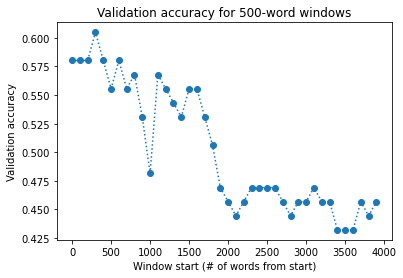

In [17]:
plt.plot(x, np.array(accuracy), marker='o', linestyle=':')
plt.ylabel('Validation accuracy')
plt.xlabel('Window start (# of words from start)')
plt.title('Validation accuracy for 500-word windows')
plt.show()

#### Now try reversing the word order in the documents

In [18]:
WINDOW = 500
accuracy = []
F1 = []
x = []

for i in range(40):
    cut_start = i * 100
    cut_stop = cut_start + WINDOW
    window_data = [' '.join(i[::-1].split(' ')[cut_start:cut_stop]) for i in data['cleaned_contents']]
    window_y_hat = np.array(predictor.predict(window_data), dtype='int64')
    accuracy.append((window_y_hat == y).sum() / len(y))
    TP = ((window_y_hat == 1) & (y == 1)).sum()
    FP = ((window_y_hat == 1) & (y == 0)).sum()
    FN = ((window_y_hat == 0) & (y == 1)).sum()
    F1.append(2 * TP / (2 * TP + FP + FN))
    x.append(cut_start)

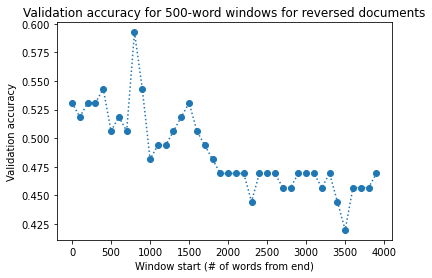

In [19]:
plt.plot(x, np.array(accuracy), marker='o', linestyle=':')
plt.ylabel('Validation accuracy')
plt.xlabel('Window start (# of words from end)')
plt.title('Validation accuracy for 500-word windows for reversed documents')
plt.show()

In [20]:
predictor.save('./cnn_80_10_10')